In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
import uproot as ur
import re

In [14]:
with open("../../genIII_data/JLab/Ptrg/1-63-60-Ptrg.pkl", 'rb') as file:
    ped = pickle.load(file)
with open("../../genIII_data/UCR/Cosmic/O9-63-60-Avg-MIPs.pkl", 'rb') as file:
    mip = pickle.load(file)
with open("../../genIII_data/JLab/Beam/1-63-60-HGLG.pkl", 'rb') as file:
    ratio = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)

In [9]:
input_file = f"../../genIII_data/JLab/Beam/1-63-60-Beam.root"

events = ur.open("%s:raw"%(input_file))

In [10]:
beam = {}

for ch_key in events.keys():
    match = re.match(r"ch_(\d+)", ch_key)
    if not match:
        continue

    ID = int(match.group(1))
    values = np.array(events[ch_key])  # (n_events, 2) — each row is (LG, HG)

    # Initialize lists
    if f"{ID}_LG" not in beam:
        beam[f"{ID}_LG"] = []
        beam[f"{ID}_HG"] = []

    for i, (LG, HG) in enumerate(values):
        beam[f"{ID}_LG"].append(float(LG))
        beam[f"{ID}_HG"].append(float(HG))

Text(0, 0.5, 'Count')

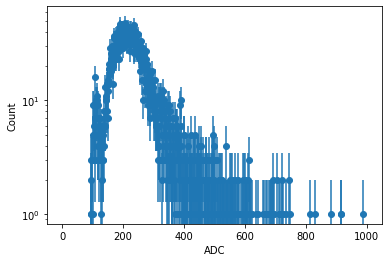

In [11]:
data = np.array(beam["12_LG"])
counts, bin_edges = np.histogram(data, bins=1000, range=[0, 1000])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o')
plt.yscale('log')
#plt.ylim(1,25)
plt.xlabel("ADC")
plt.ylabel("Count")


In [12]:
def get_chIDs_by_layer(df, layer_number):
    ch_ids = []
    for ch_str in df[df['Layer'] == layer_number]['Ch#']:
        CAEN, ch = map(int, ch_str.split('-'))
        ch_id = ch + (64 * (CAEN - 1))
        ch_ids.append(ch_id)
    return ch_ids
def get_LG_array_by_layer(geometry, din):
    all_layers = sorted(geometry['Layer'].unique())
    layer_data = []

    for layer in all_layers:
        ch_ids = get_chIDs_by_layer(geometry, layer)
        combined = [din[f"{ID}_LG"] for ID in ch_ids if f"{ID}_LG" in din]
        if combined:
            layer_data.append(np.concatenate(combined))
        else:
            layer_data.append(np.array([]))  # empty array if no matches

    return layer_data

In [31]:
num_channels = 64 * 6
num_events = len(next(iter(beam.values())))  # assumes all channels have same number of events

# Convert geometry to lookup-friendly form
geometry_lookup = geometry.set_index("Ch#")

# We'll fill this with lists first, then convert to np.array
beam_lg_mips = []

for evt in range(num_events):
    event_data = []
    for ch in range(num_channels):
        key_lg = f"{ch}_LG"

        if key_lg in beam:
            raw_value = beam[key_lg][evt]
            ped_mean = ped['LGPedMean'][ch]
            ped_sigma = ped['LGPedSigma'][ch]
            ratio_i = ratio[ch]
            mip_i = mip[ch]

            val_subtracted = raw_value - ped_mean
            if val_subtracted < 3 * ped_sigma or ratio_i == 0 or mip_i == 0:
                event_data.append([0, 0, 0, 0])
            else:
                lg_mip = (val_subtracted * ratio_i) / mip_i

                # Only add if lg_mip > 0
                if lg_mip > 0:
                    if ch in geometry_lookup.index:
                        x = geometry_lookup.at[ch, "x"]
                        y = geometry_lookup.at[ch, "y"]
                        z = geometry_lookup.at[ch, "z"]
                        event_data.append([lg_mip, x, y, z])
                    else:
                        event_data.append([lg_mip, 0, 0, 0])
                else:
                    event_data.append([0, 0, 0, 0])
        else:
            event_data.append([0, 0, 0, 0])
    beam_lg_mips.append(event_data)

# Convert to NumPy array
beam_lg_mips = np.array(beam_lg_mips)

In [38]:
print(len(beam_lg_mips))

5293


In [35]:
with open('../../genIII_data/JLab/Beam/1-63-60-Beam-Cal.pkl', 'wb') as f:
    pickle.dump(beam_lg_mips, f)